In [1]:
%matplotlib inline
import random
import time 
import torch
import torch.nn as nn
from torch.nn import init
import numpy as np
import pandas as pd
from IPython import display
from collections import OrderedDict
import sys
import d2lzh as d2l
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d


# 7.优化

在优化中，这样的损失函数通常被称作优化问题的⽬标函数（objective function）

依据惯例，优化算法通常只
考虑最⼩化⽬标函数。其实，任何最⼤化问题都可以很容易地转化为最⼩化问题，只需令⽬标函数的相
反数为新的⽬标函数即可。

### 优化与深度学习的区别
由于优化算法的⽬标函数通常是⼀个基于训练数据集的损失函数，优化的⽬标在于降低训练误差。 ⽽深度学习的⽬标在于降低泛化误差。为了降低泛化误差，除了使⽤优化算法降低训练误差以外，还需要注意应对过拟合。

### 优化在深度学习中的挑战
我们在3.1节（线性回归）中对优化问题的解析解和数值解做了区分。深度学习中绝⼤多数⽬标函数都很复杂。

因此，很多优化问题并不存在解析解，⽽需要使⽤基于数值⽅法的优化算法找到近似解，即数值解。

本书中讨论的优化算法都是这类基于数值⽅法的算法。为了求得最⼩化⽬标函数的数值解，我们将通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。

优化在深度学习中有很多挑战。下⾯描述了其中的两个挑战，即局部最⼩值和鞍点。

Text(0, 0.5, 'f(x)')

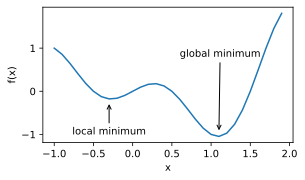

In [3]:
####  局部最⼩值

def f(x):
 return x * np.cos(np.pi * x)
d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77,-1.0),arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6,0.8),arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')

深度学习模型的⽬标函数可能有若⼲局部最优值。当⼀个优化问题的数值解在局部最优解附近时，由于⽬标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令⽬标函数局部最⼩化⽽⾮全局最⼩化。

#### 7.1.2.2 鞍点

刚刚我们提到，梯度接近或变成零可能是由于当前解在局部最优解附近造成的。事实上，另一种可能性是当前解在鞍点（saddle point）附近。

 举个定义在二维空间的函数的例子，例如：

$$f(x, y) = x^2 - y^2.$$

我们可以找出该函数的鞍点位置。也许你已经发现了，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。


Text(0.5, 0, 'y')

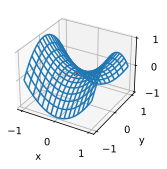

In [7]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

在图的鞍点位置，目标函数在$x$轴方向上是局部最小值，但在$y$轴方向上是局部最大值。

假设一个函数的输入为$k$维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

* 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
* 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
* 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5。那么，以上第一种情况的概率为 $0.5^k$。由于深度学习模型参数通常都是高维的（$k$很大），目标函数的鞍点通常比局部最小值更常见。

在深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在本章接下来的几节中逐一介绍深度学习中常用的优化算法，它们在很多实际问题中都能够训练出十分有效的深度学习模型。


### 小结

* 由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。
* 由于深度学习模型参数通常都是高维的，目标函数的鞍点通常比局部最小值更常见。

## 7.2 梯度下降和随机梯度下降

梯度的意义以及沿着梯度反⽅向更新⾃变量可能降低⽬标函数值的原因是学习后续
优化算法的基础

### 7.2.1 一维梯度下降

我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。假设连续可导的函数$f: \mathbb{R} \rightarrow \mathbb{R}$的输入和输出都是标量。给定绝对值足够小的数$\epsilon$，根据泰勒展开公式，我们得到以下的近似：

$$f(x + \epsilon) \approx f(x) + \epsilon f'(x) .$$

这里$f'(x)$是函数$f$在$x$处的梯度。一维函数的梯度是一个标量，也称导数。

接下来，找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到

$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以

$$f(x - \eta f'(x)) \lesssim f(x).$$

这意味着，如果通过

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。



下面我们以目标函数$f(x)=x^2$为例来看一看梯度下降是如何工作的。虽然我们知道最小化$f(x)$的解为$x=0$，这里依然使用这个简单函数来观察$x$是如何被迭代的。来使⽤x = 10 作为初始值$\eta = 0.2$，并设 。使⽤梯度下降对 迭代10次，可⻅最终 的值较接近最优解

epoch 10, x: 0.06046617599999997


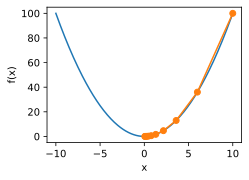

In [13]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

# 绘制出⾃变量 的迭代轨迹
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [x * x for x in f_line])
    d2l.plt.plot(res, [x * x for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')

show_trace(res)

### 7.2.2 学习率

梯度下降算法中的正数$\eta$通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致$x$更新缓慢从而需要更多的迭代才能得到较好的解。

下面展示使用学习率$\eta=0.05$时自变量$x$的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终$x$的值依然与最优解存在较大偏差。

epoch 10, x: 3.4867844009999995


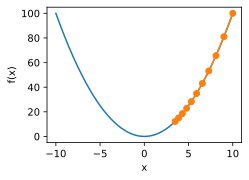

In [14]:
show_trace(gd(0.05))


 如果使用过大的学习率，$\left|\eta f'(x)\right|$可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代$x$会降低$f(x)$的值。

举个例子，当设学习率$\eta=1.1$时，可以看到$x$不断越过（overshoot）最优解$x=0$并逐渐发散。

epoch 10, x: 61.917364224000096


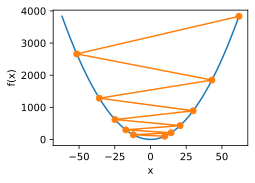

In [15]:
show_trace(gd(1.1))

### 7.2.3 多维梯度下降

在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$


为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$（即$\|\boldsymbol{u}\|=1$）方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

依据方向导数性质[1，14.6节定理三]，以上方向导数可以改写为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$，
其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$$

同样，其中$\eta$（取正数）称作学习率。

下面我们构造一个输入为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和输出为标量的目标函数$f(\boldsymbol{x})=x_1^2+2x_2^2$。那么，梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$。我们将观察梯度下降从初始位置$[-5,-2]$开始对自变量$\boldsymbol{x}$的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置$[-5,-2]$开始迭代自变量$\boldsymbol{x}$共20次，第二个函数对自变量$\boldsymbol{x}$的迭代轨迹进行可视化。

epoch 20, x1 -0.057646, x2 -0.000073


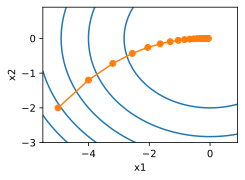

In [18]:
def train_2d(trainer):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

# 然后，观察学习率为 0.1 时⾃变量的迭代轨迹。使⽤梯度下降对⾃变量 x迭代20次后，可⻅最终 x的值较
# 接近最优解[0,0]。
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

## 7.2.4 随机梯度下降

在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设$f_i(\boldsymbol{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，$\boldsymbol{x}$是模型的参数向量，那么目标函数定义为

$$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).$$

目标函数在$\boldsymbol{x}$处的梯度计算为

$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).$$

如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着$n$线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

随机梯度下降（stochastic gradient descent，SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in\{1,\ldots,n\}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代$\boldsymbol{x}$：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).$$

这里$\eta$同样是学习率。可以看到每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。值得强调的是，随机梯度$\nabla f_i(\boldsymbol{x})$是对梯度$\nabla f(\boldsymbol{x})$的无偏估计：

$$E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

epoch 20, x1 -0.152307, x2 -0.046180


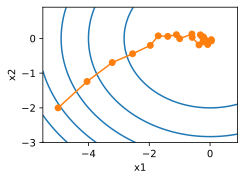

In [19]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

可以看到，随机梯度下降中⾃变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加
的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的⽆意义的⼲扰

### 小结

* 使用适当的学习率，沿着梯度反方向更新自变量可能降低目标函数值。梯度下降重复这一更新过程直到得到满足要求的解。
* 学习率过大或过小都有问题。一个合适的学习率通常是需要通过多次实验找到的。(*感觉这部分算是trick把*)
* 当训练数据集的样本较多时，梯度下降每次迭代的计算开销较大，因而随机梯度下降通常更受青睐。

## 7.3 ⼩批量随机梯度下降

在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）。而随机梯度下降在每次迭代中只随机采样一个样本来计算梯度。正如我们在前几章中所看到的，我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。下面就来描述小批量随机梯度下降。


设目标函数$f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$。在迭代开始前的时间步设为0。该时间步的自变量记为$\boldsymbol{x}_0\in \mathbb{R}^d$，通常由随机初始化得到。在接下来的每一个时间步$t>0$中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$。我们可以通过重复采样（sampling with replacement）或者不重复采样（sampling without replacement）得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用

$$
\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})
$$

来计算时间步$t$的小批量$\mathcal{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$。这里$|\mathcal{B}|$代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计。给定学习率$\eta_t$（取正数），小批量随机梯度下降对自变量的迭代如下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减，例如$\eta_t=\eta t^\alpha$（通常$\alpha=-1$或者$-0.5$）、$\eta_t = \eta \alpha^t$（如$\alpha=0.95$）或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。


小批量随机梯度下降中每次迭代的计算开销为$\mathcal{O}(|\mathcal{B}|)$。当批量大小为1时，该算法即为随机梯度下降；当批量大小等于训练数据样本数时，该算法即为梯度下降。当批量较小时，每次迭代中使用的样本少，这会导致并行处理和内存使用效率变低。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的冗余信息。为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多，例如增大迭代周期数。

## 7.3.1 读取数据
本章里我们将使用一个来自NASA的测试不同飞机机翼噪音的数据集来比较各个优化算法 [1]。我们使用该数据集的前1,500个样本和5个特征，并使用标准化对数据进行预处理。

In [25]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('./Datasets/airfoil_self_noise.dat', delimiter='\t')
    # print(data.shape)
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])

def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

# 它初始化⼀个线性回归模型，然后可以使⽤⼩批量随机梯度下降以及后续⼩节介绍的其他算法来训练模型。
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

当批量⼤⼩为样本总数1,500时，优化使⽤的是梯度下降。梯度下降的1个迭代周期对模型参数只迭代1次。可以看到6次迭代后⽬标函数值（训练损失）的下降趋向了平稳

loss: 0.244659, 0.021854 sec per epoch


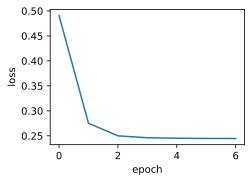

In [26]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size,
num_epochs)
train_sgd(1, 1500, 6)

当批量⼤⼩为1时，优化使⽤的是随机梯度下降。为了简化实现，有关（⼩批量）随机梯度下降的实验
中，我们未对学习率进⾏⾃我衰减，⽽是直接采⽤较⼩的常数学习率。随机梯度下降中，每处理⼀个样
本会更新⼀次⾃变量（模型参数），⼀个迭代周期⾥会对⾃变量进⾏1,500次更新。可以看到，⽬标函
数值的下降在1个迭代周期后就变得较为平缓。

loss: 0.245135, 1.834597 sec per epoch


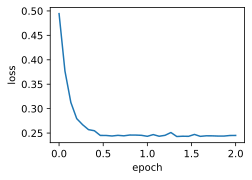

In [27]:
train_sgd(0.005, 1)

虽然随机梯度下降和梯度下降在⼀个迭代周期⾥都处理了1,500个样本，但实验中随机梯度下降的⼀个
迭代周期耗时更多。这是因为随机梯度下降在⼀个迭代周期⾥做了更多次的⾃变量迭代，⽽且单样本的
梯度计算难以有效利⽤⽮量计算。
当批量⼤⼩为10时，优化使⽤的是⼩批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机
梯度下降的耗时之间。

loss: 0.247031, 0.191048 sec per epoch


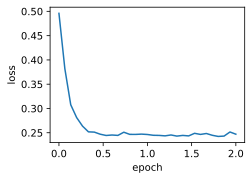

In [28]:
train_sgd(0.05, 10)

loss: 0.244576, 0.121029 sec per epoch


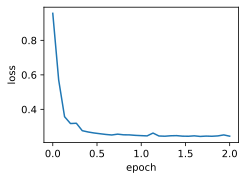

In [31]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams,features, labels, batch_size=10, num_epochs=2):

    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels),batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

# 使用pytorch重复上一个实验
train_pytorch_ch7(torch.optim.SGD, {"lr": 0.05}, features, labels, 10)


### 小结

* 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
* 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
* 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

## 7.4 动量法

如果⾃变量的迭代⽅向仅仅取决于⾃变量当前位置，这可能会带来⼀些问题

